#Multilayered, ODE
#Simple exponential equation

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3202: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size


Initial cost: 309.797
Final cost: 0.000753208


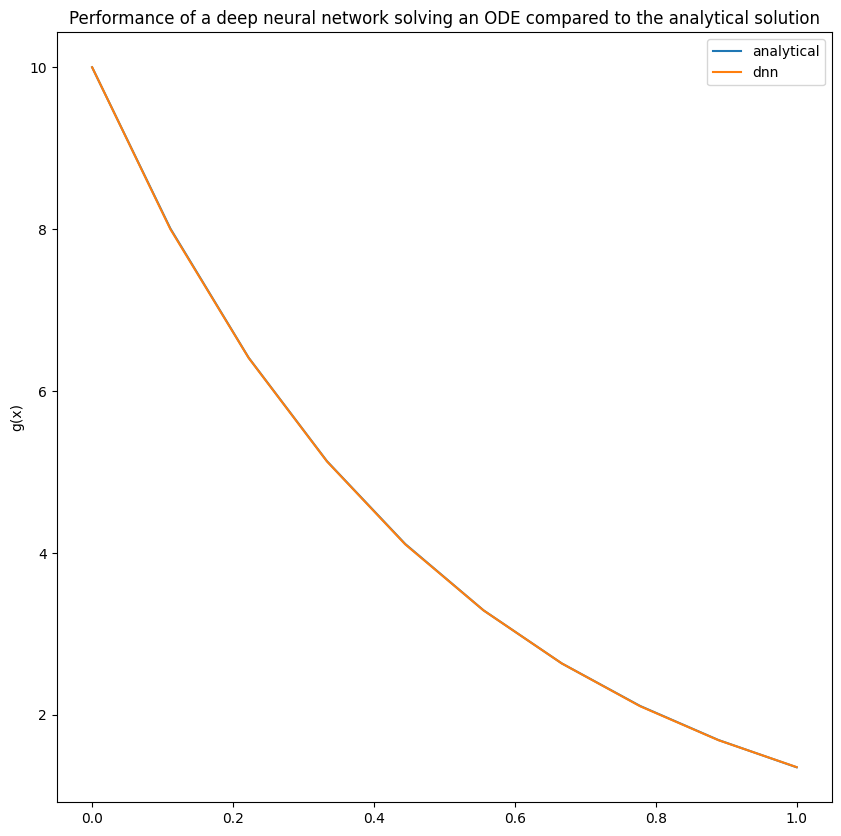

In [ ]:
import autograd.numpy as np
from autograd import grad, elementwise_grad
import autograd.numpy.random as npr
from matplotlib import pyplot as plt

def sigmoid(z):
    return 1/(1 + np.exp(-z))

# The neural network with one input layer and one output layer,
# but with number of hidden layers specified by the user.
def deep_neural_network(deep_params, x):
    # N_hidden is the number of hidden layers

    N_hidden = np.size(deep_params) - 1 # -1 since params consists of parameters to all the hidden layers AND the output layer.

    # Assumes input x being an one-dimensional array
    num_values = np.size(x)
    x = x.reshape(-1, num_values)

    # Assume that the input layer does nothing to the input x
    x_input = x

    # Due to multiple hidden layers, define a variable referencing to the output of the previous layer:
    x_prev = x_input

    ## Hidden layers:
    for l in range(N_hidden):
        # From the list of parameters P; find the correct weigths and bias for this layer
        w_hidden = deep_params[l]

        # Add a row of ones to include bias
        x_prev = np.concatenate((np.ones((1,num_values)), x_prev ), axis = 0)

        z_hidden = np.matmul(w_hidden, x_prev)
        x_hidden = sigmoid(z_hidden)

        # Update x_prev such that next layer can use the output from this layer
        x_prev = x_hidden

    ## Output layer:
    # Get the weights and bias for this layer
    w_output = deep_params[-1]

    # Include bias:
    x_prev = np.concatenate((np.ones((1,num_values)), x_prev), axis = 0)

    z_output = np.matmul(w_output, x_prev)
    x_output = z_output

    return x_output

# The trial solution using the deep neural network:
def g_trial_deep(x,params, g0 = 10):
    return g0 + x*deep_neural_network(params, x)

# The right side of the ODE:
def g(x, g_trial, gamma = 2):
    return -gamma*g_trial

# The same cost function as before, but calls deep_neural_network instead.
def cost_function_deep(P, x):

    # Evaluate the trial function with the current parameters P
    g_t = g_trial_deep(x,P)

    # Find the derivative w.r.t x of the neural network
    d_net_out = elementwise_grad(deep_neural_network,1)(P,x)

    # Find the derivative w.r.t x of the trial function
    d_g_t = elementwise_grad(g_trial_deep,0)(x,P)

    # The right side of the ODE
    func = g(x, g_t)

    err_sqr = (d_g_t - func)**2
    cost_sum = np.sum(err_sqr)

    return cost_sum / np.size(err_sqr)

# Solve the exponential decay ODE using neural network with one input and one output layer,
# but with specified number of hidden layers from the user.
def solve_ode_deep_neural_network(x, num_neurons, num_iter, lmb):
    # num_hidden_neurons is now a list of number of neurons within each hidden layer
    # The number of elements in the list num_hidden_neurons thus represents the number of hidden layers.

    # Find the number of hidden layers:
    N_hidden = np.size(num_neurons)

    ## Set up initial weights and biases
    # Initialize the list of parameters:
    P = [None]*(N_hidden + 1) # + 1 to include the output layer

    P[0] = npr.randn(num_neurons[0], 2 )
    for l in range(1,N_hidden):
        P[l] = npr.randn(num_neurons[l], num_neurons[l-1] + 1) # +1 to include bias

    # For the output layer
    P[-1] = npr.randn(1, num_neurons[-1] + 1 ) # +1 since bias is included

    print('Initial cost: %g'%cost_function_deep(P, x))

    cost_function_deep_grad = grad(cost_function_deep,0)

    # Let the update be done num_iter times
    for i in range(num_iter):
        # Evaluate the gradient at the current weights and biases in P.
        # The cost_grad consist now of N_hidden + 1 arrays; the gradient w.r.t the weights and biases in the hidden layers and output layers evaluated at x.
        cost_deep_grad =  cost_function_deep_grad(P, x)

        for l in range(N_hidden+1):
            P[l] = P[l] - lmb * cost_deep_grad[l]

    print('Final cost: %g'%cost_function_deep(P, x))

    return P

def g_analytic(x, gamma = 2, g0 = 10):
    return g0*np.exp(-gamma*x)

# Solve the given problem
if __name__ == '__main__':
    npr.seed(15)

    ## Decide the vales of arguments to the function to solve
    N = 10
    x = np.linspace(0, 1, N)

    ## Set up the initial parameters
    num_hidden_neurons = np.array([25,15])
    num_iter = 10000
    lmb = 0.01

    P = solve_ode_deep_neural_network(x, num_hidden_neurons, num_iter, lmb)

    res = g_trial_deep(x,P)
    res_analytical = g_analytic(x)

    plt.figure(figsize=(10,10))

    plt.title('Performance of a deep neural network solving an ODE compared to the analytical solution')
    plt.plot(x, res_analytical)
    plt.plot(x, res[0,:])
    plt.legend(['analytical','dnn'])
    plt.ylabel('g(x)')
    plt.show()

# POISSON

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size


Initial cost: 196.481
Final cost: 0.000204531
The max absolute difference between the solutions is: 0.000159952


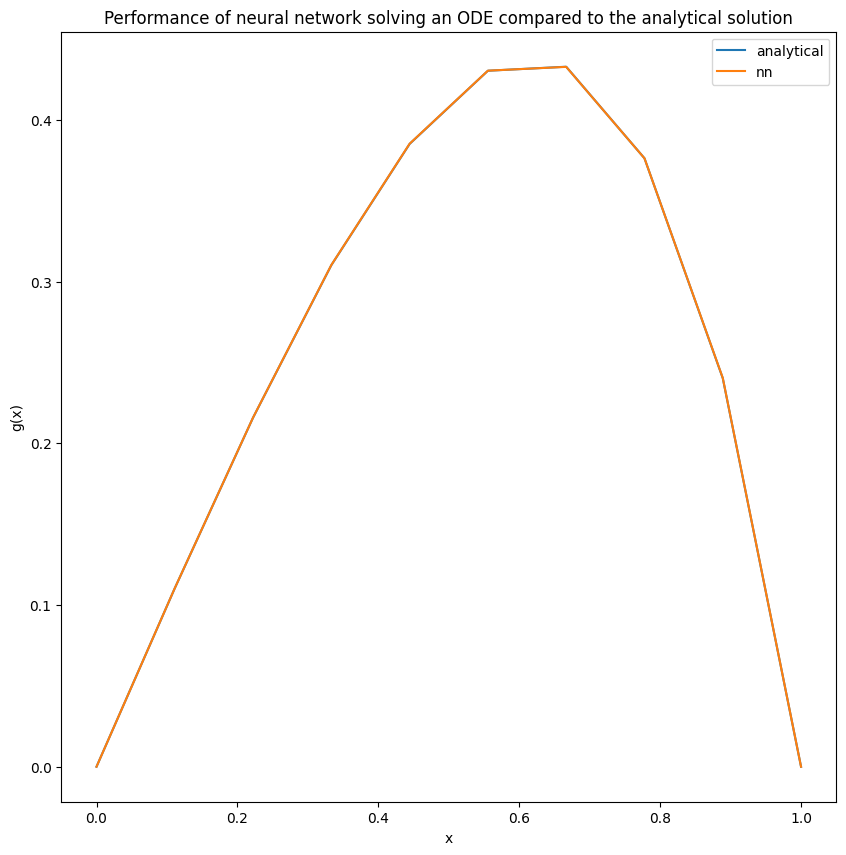

In [ ]:
import autograd.numpy as np
from autograd import grad, elementwise_grad
import autograd.numpy.random as npr
from matplotlib import pyplot as plt

def sigmoid(z):
    return 1/(1 + np.exp(-z))

def deep_neural_network(deep_params, x):
    # N_hidden is the number of hidden layers
    N_hidden = np.size(deep_params) - 1 # -1 since params consist of parameters to all the hidden layers AND the output layer

    # Assumes input x being an one-dimensional array
    num_values = np.size(x)
    x = x.reshape(-1, num_values)

    # Assume that the input layer does nothing to the input x
    x_input = x

    # Due to multiple hidden layers, define a variable referencing to the
    # output of the previous layer:
    x_prev = x_input

    ## Hidden layers:

    for l in range(N_hidden):
        # From the list of parameters P; find the correct weigths and bias for this layer
        w_hidden = deep_params[l]

        # Add a row of ones to include bias
        x_prev = np.concatenate((np.ones((1,num_values)), x_prev ), axis = 0)

        z_hidden = np.matmul(w_hidden, x_prev)
        x_hidden = sigmoid(z_hidden)

        # Update x_prev such that next layer can use the output from this layer
        x_prev = x_hidden

    ## Output layer:

    # Get the weights and bias for this layer
    w_output = deep_params[-1]

    # Include bias:
    x_prev = np.concatenate((np.ones((1,num_values)), x_prev), axis = 0)

    z_output = np.matmul(w_output, x_prev)
    x_output = z_output

    return x_output

def solve_ode_deep_neural_network(x, num_neurons, num_iter, lmb):
    # num_hidden_neurons is now a list of number of neurons within each hidden layer

    # Find the number of hidden layers:
    N_hidden = np.size(num_neurons)

    ## Set up initial weigths and biases

    # Initialize the list of parameters:
    P = [None]*(N_hidden + 1) # + 1 to include the output layer

    P[0] = npr.randn(num_neurons[0], 2 )
    for l in range(1,N_hidden):
        P[l] = npr.randn(num_neurons[l], num_neurons[l-1] + 1) # +1 to include bias

    # For the output layer
    P[-1] = npr.randn(1, num_neurons[-1] + 1 ) # +1 since bias is included

    print('Initial cost: %g'%cost_function_deep(P, x))

    ## Start finding the optimal weigths using gradient descent

    # Find the Python function that represents the gradient of the cost function
    # w.r.t the 0-th input argument -- that is the weights and biases in the hidden and output layer
    cost_function_deep_grad = grad(cost_function_deep,0)

    # Let the update be done num_iter times
    for i in range(num_iter):
        # Evaluate the gradient at the current weights and biases in P.
        # The cost_grad consist now of N_hidden + 1 arrays; the gradient w.r.t the weights and biases
        # in the hidden layers and output layers evaluated at x.
        cost_deep_grad =  cost_function_deep_grad(P, x)

        for l in range(N_hidden+1):
            P[l] = P[l] - lmb * cost_deep_grad[l]

    print('Final cost: %g'%cost_function_deep(P, x))

    return P

## Set up the cost function specified for this Poisson equation:

# The right side of the ODE
def f(x):
    return (3*x + x**2)*np.exp(x)

def cost_function_deep(P, x):

    # Evaluate the trial function with the current parameters P
    g_t = g_trial_deep(x,P)

    # Find the derivative w.r.t x of the trial function
    d2_g_t = elementwise_grad(elementwise_grad(g_trial_deep,0))(x,P)

    right_side = f(x)

    err_sqr = (-d2_g_t - right_side)**2
    cost_sum = np.sum(err_sqr)

    return cost_sum/np.size(err_sqr)

# The trial solution:
def g_trial_deep(x,P):
    return x*(1-x)*deep_neural_network(P,x)

# The analytic solution;
def g_analytic(x):
    return x*(1-x)*np.exp(x)

if __name__ == '__main__':
    npr.seed(4155)

    ## Decide the vales of arguments to the function to solve
    Nx = 10
    x = np.linspace(0,1, Nx)

    ## Set up the initial parameters
    num_hidden_neurons = [20,10]
    num_iter = 10000
    lmb = 0.01

    P = solve_ode_deep_neural_network(x, num_hidden_neurons, num_iter, lmb)

    g_dnn_ag = g_trial_deep(x,P)
    g_analytical = g_analytic(x)

    # Find the maximum absolute difference between the solutons:
    max_diff = np.max(np.abs(g_dnn_ag - g_analytical))
    print("The max absolute difference between the solutions is: %g"%max_diff)

    plt.figure(figsize=(10,10))

    plt.title('Performance of neural network solving an ODE compared to the analytical solution')
    plt.plot(x, g_analytical)
    plt.plot(x, g_dnn_ag[0,:])
    plt.legend(['analytical','nn'])
    plt.xlabel('x')
    plt.ylabel('g(x)')
    plt.show()

# Lane-Emden (n=0,a=1)

Initial cost: 2.76731
Final cost: 5.35432e-07
The max absolute difference between the solutions is: 0.000215458


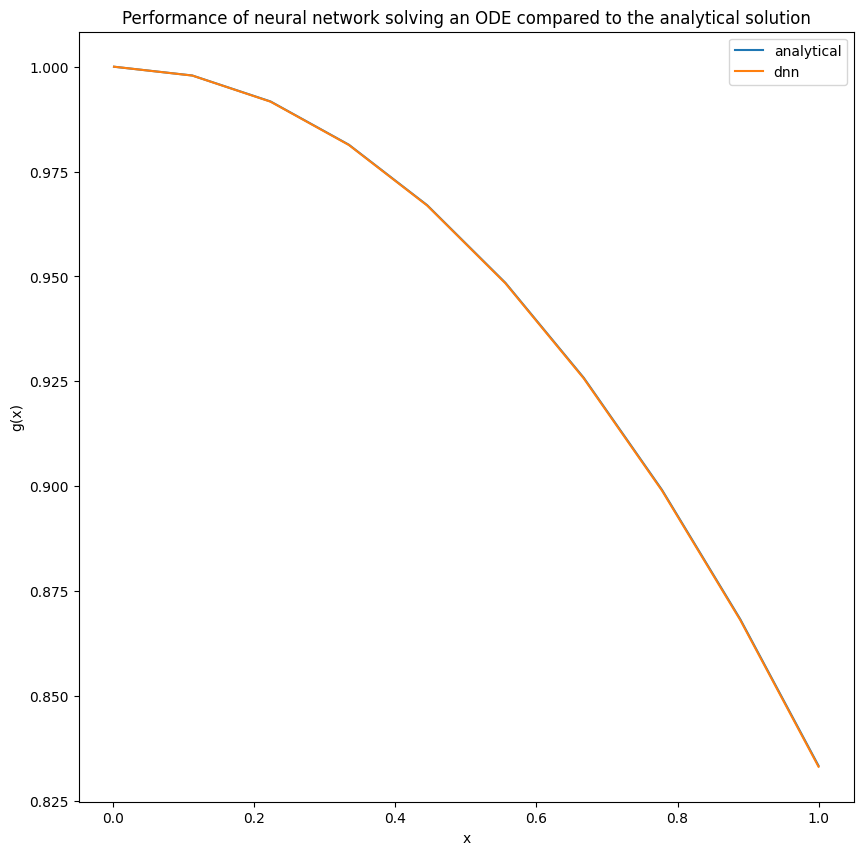

In [ ]:
import autograd.numpy as np
from autograd import grad, elementwise_grad
import autograd.numpy.random as npr
from matplotlib import pyplot as plt

def sigmoid(z):
    return 1/(1 + np.exp(-z))

def deep_neural_network(deep_params, x):
    # N_hidden is the number of hidden layers
    N_hidden = np.size(deep_params) - 1 # -1 since params consist of parameters to all the hidden layers AND the output layer

    # Assumes input x being an one-dimensional array
    num_values = np.size(x)
    x = x.reshape(-1, num_values)

    # Assume that the input layer does nothing to the input x
    x_input = x

    # Due to multiple hidden layers, define a variable referencing to the
    # output of the previous layer:
    x_prev = x_input

    ## Hidden layers:

    for l in range(N_hidden):
        # From the list of parameters P; find the correct weigths and bias for this layer
        w_hidden = deep_params[l]

        # Add a row of ones to include bias
        x_prev = np.concatenate((np.ones((1,num_values)), x_prev ), axis = 0)

        z_hidden = np.matmul(w_hidden, x_prev)
        x_hidden = sigmoid(z_hidden)

        # Update x_prev such that next layer can use the output from this layer
        x_prev = x_hidden

    ## Output layer:

    # Get the weights and bias for this layer
    w_output = deep_params[-1]

    # Include bias:
    x_prev = np.concatenate((np.ones((1,num_values)), x_prev), axis = 0)

    z_output = np.matmul(w_output, x_prev)
    x_output = z_output

    return x_output

def solve_ode_deep_neural_network(x, num_neurons, num_iter, lmb):
    # num_hidden_neurons is now a list of number of neurons within each hidden layer

    # Find the number of hidden layers:
    N_hidden = np.size(num_neurons)

    ## Set up initial weigths and biases

    # Initialize the list of parameters:
    P = [None]*(N_hidden + 1) # + 1 to include the output layer

    P[0] = npr.randn(num_neurons[0], 2 )
    for l in range(1,N_hidden):
        P[l] = npr.randn(num_neurons[l], num_neurons[l-1] + 1) # +1 to include bias

    # For the output layer
    P[-1] = npr.randn(1, num_neurons[-1] + 1 ) # +1 since bias is included

    print('Initial cost: %g'%cost_function_deep(P, x))

    ## Start finding the optimal weigths using gradient descent

    # Find the Python function that represents the gradient of the cost function
    # w.r.t the 0-th input argument -- that is the weights and biases in the hidden and output layer
    cost_function_deep_grad = grad(cost_function_deep,0)

    # Let the update be done num_iter times
    for i in range(num_iter):
        # Evaluate the gradient at the current weights and biases in P.
        # The cost_grad consist now of N_hidden + 1 arrays; the gradient w.r.t the weights and biases
        # in the hidden layers and output layers evaluated at x.
        cost_deep_grad =  cost_function_deep_grad(P, x)

        for l in range(N_hidden+1):
            P[l] = P[l] - lmb * cost_deep_grad[l]

    print('Final cost: %g'%cost_function_deep(P, x))

    return P

## Set up the cost function specified for this  equation:

# The right side of the ODE
def f(x):
      return -((2/x)*elementwise_grad(g_analytic,0)(x)+1)

def cost_function_deep(P, x):

    # Evaluate the trial function with the current parameters P
    g_t = g_trial_deep(x,P)

    # Find the derivative w.r.t x of the trial function
    d2_g_t = elementwise_grad(elementwise_grad(g_trial_deep,0))(x,P)

    right_side = f(x)

    err_sqr = (d2_g_t - right_side)**2
    cost_sum = np.sum(err_sqr)

    return cost_sum/np.size(err_sqr)

# The trial solution:
def g_trial_deep(x,P):
    return 1 - (x**2)*deep_neural_network(P,x)

# The analytic solution;
def g_analytic(x):
    return 1 - (x**2)/6

if __name__ == '__main__':
    npr.seed(4155)

    ## Decide the vales of arguments to the function to solve
    Nx = 10
    x = np.linspace(0.001,1, Nx)

    ## Set up the initial parameters
    num_hidden_neurons = [50,50]
    num_iter = 10000
    lmb = 0.01

    P = solve_ode_deep_neural_network(x, num_hidden_neurons, num_iter, lmb)

    g_dnn_ag = g_trial_deep(x,P)
    g_analytical = g_analytic(x)

    # Find the maximum absolute difference between the solutons:
    max_diff = np.max(np.abs(g_dnn_ag - g_analytical))
    print("The max absolute difference between the solutions is: %g"%max_diff)

    plt.figure(figsize=(10,10))

    plt.title('Performance of neural network solving an ODE compared to the analytical solution')
    plt.plot(x, g_analytical)
    plt.plot(x, g_dnn_ag[0,:])
    plt.legend(['analytical','dnn'])
    plt.xlabel('x')
    plt.ylabel('g(x)')
    plt.show()

# Lane-Emden (n=1,a=1)

Initial cost: 86.9107
Final cost: 0.000177091
The max absolute difference between the solutions is: 0.000305726


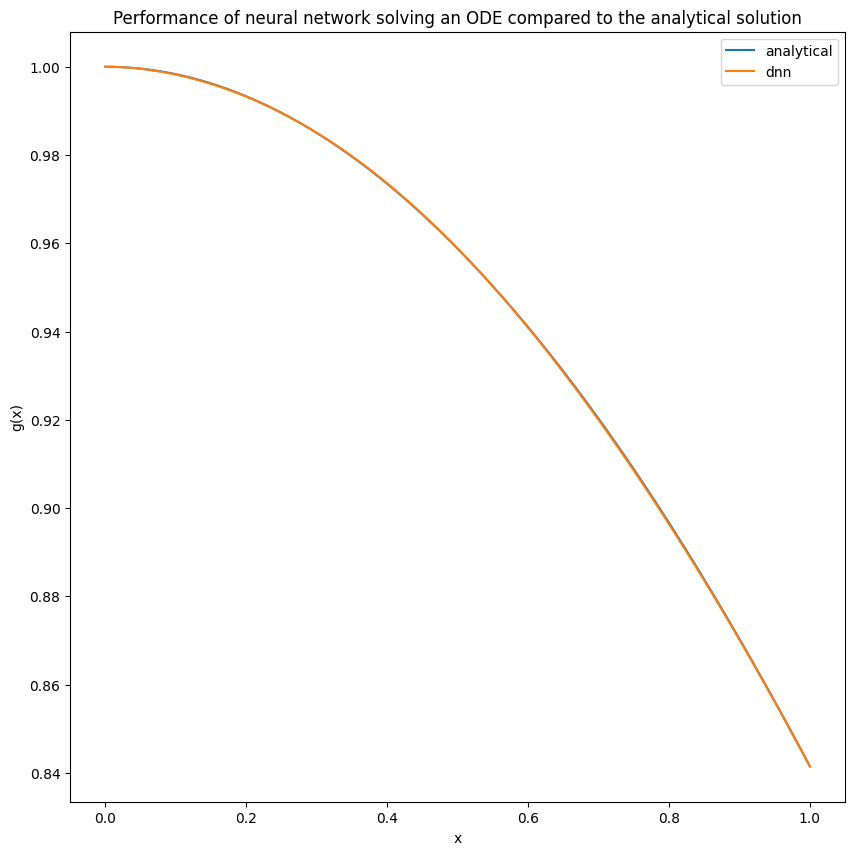

In [ ]:
import autograd.numpy as np
from autograd import grad, elementwise_grad
import autograd.numpy.random as npr
from matplotlib import pyplot as plt

def sigmoid(z):
    return 1/(1 + np.exp(-z))

def deep_neural_network(deep_params, x):
    # N_hidden is the number of hidden layers
    N_hidden = np.size(deep_params) - 1 # -1 since params consist of parameters to all the hidden layers AND the output layer

    # Assumes input x being an one-dimensional array
    num_values = np.size(x)
    x = x.reshape(-1, num_values)

    # Assume that the input layer does nothing to the input x
    x_input = x

    # Due to multiple hidden layers, define a variable referencing to the
    # output of the previous layer:
    x_prev = x_input

    ## Hidden layers:

    for l in range(N_hidden):
        # From the list of parameters P; find the correct weigths and bias for this layer
        w_hidden = deep_params[l]

        # Add a row of ones to include bias
        x_prev = np.concatenate((np.ones((1,num_values)), x_prev ), axis = 0)

        z_hidden = np.matmul(w_hidden, x_prev)
        x_hidden = sigmoid(z_hidden)

        # Update x_prev such that next layer can use the output from this layer
        x_prev = x_hidden

    ## Output layer:

    # Get the weights and bias for this layer
    w_output = deep_params[-1]

    # Include bias:
    x_prev = np.concatenate((np.ones((1,num_values)), x_prev), axis = 0)

    z_output = np.matmul(w_output, x_prev)
    x_output = z_output

    return x_output

def solve_ode_deep_neural_network(x, num_neurons, num_iter, lmb):
    # num_hidden_neurons is now a list of number of neurons within each hidden layer

    # Find the number of hidden layers:
    N_hidden = np.size(num_neurons)

    ## Set up initial weigths and biases

    # Initialize the list of parameters:
    P = [None]*(N_hidden + 1) # + 1 to include the output layer

    P[0] = npr.randn(num_neurons[0], 2 )
    for l in range(1,N_hidden):
        P[l] = npr.randn(num_neurons[l], num_neurons[l-1] + 1) # +1 to include bias

    # For the output layer
    P[-1] = npr.randn(1, num_neurons[-1] + 1 ) # +1 since bias is included

    print('Initial cost: %g'%cost_function_deep(P, x))

    ## Start finding the optimal weigths using gradient descent

    # Find the Python function that represents the gradient of the cost function
    # w.r.t the 0-th input argument -- that is the weights and biases in the hidden and output layer
    cost_function_deep_grad = grad(cost_function_deep,0)

    # Let the update be done num_iter times
    for i in range(num_iter):
        # Evaluate the gradient at the current weights and biases in P.
        # The cost_grad consist now of N_hidden + 1 arrays; the gradient w.r.t the weights and biases
        # in the hidden layers and output layers evaluated at x.
        cost_deep_grad =  cost_function_deep_grad(P, x)

        for l in range(N_hidden+1):
            P[l] = P[l] - lmb * cost_deep_grad[l]

    print('Final cost: %g'%cost_function_deep(P, x))

    return P

## Set up the cost function specified for this Poisson equation:

# The right side of the ODE
def f(x):
      return -((2/x)*elementwise_grad(g_analytic,0)(x)+g_analytic(x))

def cost_function_deep(P, x):

    # Evaluate the trial function with the current parameters P
    g_t = g_trial_deep(x,P)

    # Find the derivative w.r.t x of the trial function
    d2_g_t = elementwise_grad(elementwise_grad(g_trial_deep,0))(x,P)

    right_side = f(x)

    err_sqr = (d2_g_t - right_side)**2
    cost_sum = np.sum(err_sqr)

    return cost_sum/np.size(err_sqr)

# The trial solution:
def g_trial_deep(x,P):
    return 1 + (x**2)*deep_neural_network(P,x)

# The analytic solution;
def g_analytic(x):
    return np.sin(x)/x

if __name__ == '__main__':
    npr.seed(4155)

    ## Decide the vales of arguments to the function to solve
    Nx = 1000
    x = np.linspace(0.001,1, Nx)

    ## Set up the initial parameters
    num_hidden_neurons = [20,10]
    num_iter = 10000
    lmb = 0.01

    P = solve_ode_deep_neural_network(x, num_hidden_neurons, num_iter, lmb)

    g_dnn_ag = g_trial_deep(x,P)
    g_analytical = g_analytic(x)

    # Find the maximum absolute difference between the solutons:
    max_diff = np.max(np.abs(g_dnn_ag - g_analytical))
    print("The max absolute difference between the solutions is: %g"%max_diff)

    plt.figure(figsize=(10,10))

    plt.title('Performance of neural network solving an ODE compared to the analytical solution')
    plt.plot(x, g_analytical)
    plt.plot(x, g_dnn_ag[0,:])
    plt.legend(['analytical','dnn'])
    plt.xlabel('x')
    plt.ylabel('g(x)')
    plt.show()

# Simple First order

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size


Initial cost: 4.58521
Final cost: 0.000262311


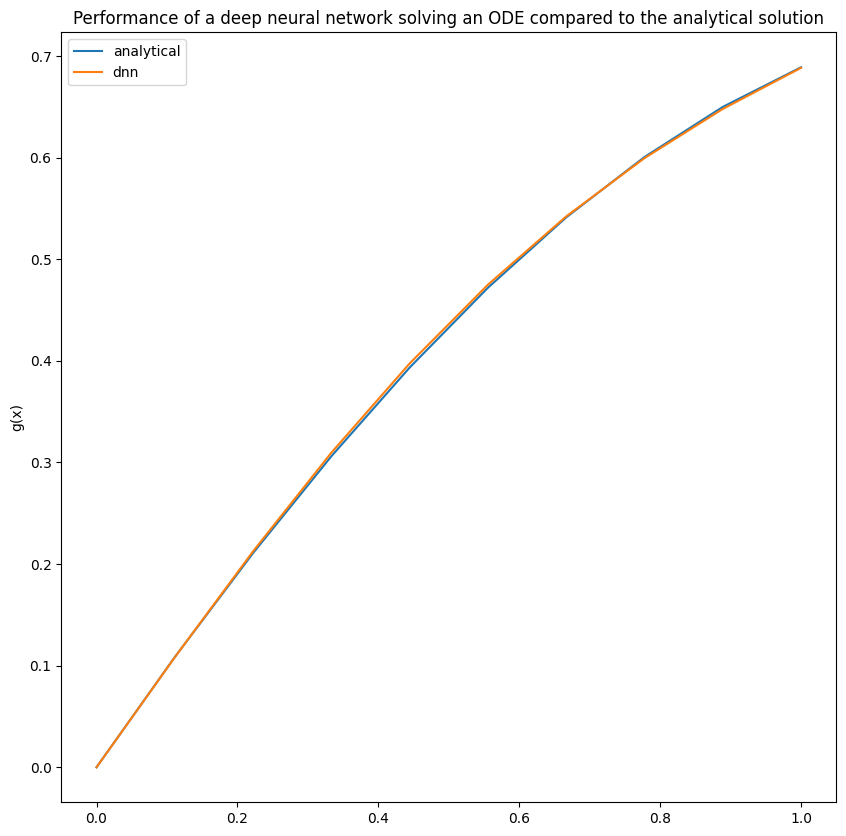

In [ ]:
import autograd.numpy as np
from autograd import grad, elementwise_grad
import autograd.numpy.random as npr
from matplotlib import pyplot as plt

def sigmoid(z):
    return 1/(1 + np.exp(-z))

# The neural network with one input layer and one output layer,
# but with number of hidden layers specified by the user.
def deep_neural_network(deep_params, x):
    # N_hidden is the number of hidden layers

    N_hidden = np.size(deep_params) - 1 # -1 since params consists of
                                        # parameters to all the hidden
                                        # layers AND the output layer.

    # Assumes input x being an one-dimensional array
    num_values = np.size(x)
    x = x.reshape(-1, num_values)

    # Assume that the input layer does nothing to the input x
    x_input = x

    # Due to multiple hidden layers, define a variable referencing to the
    # output of the previous layer:
    x_prev = x_input

    ## Hidden layers:

    for l in range(N_hidden):
        # From the list of parameters P; find the correct weigths and bias for this layer
        w_hidden = deep_params[l]

        # Add a row of ones to include bias
        x_prev = np.concatenate((np.ones((1,num_values)), x_prev ), axis = 0)

        z_hidden = np.matmul(w_hidden, x_prev)
        x_hidden = sigmoid(z_hidden)

        # Update x_prev such that next layer can use the output from this layer
        x_prev = x_hidden

    ## Output layer:

    # Get the weights and bias for this layer
    w_output = deep_params[-1]

    # Include bias:
    x_prev = np.concatenate((np.ones((1,num_values)), x_prev), axis = 0)

    z_output = np.matmul(w_output, x_prev)
    x_output = z_output

    return x_output

# The trial solution using the deep neural network:
def g_trial_deep(x,params, g0 = 10):
    return  x*deep_neural_network(params, x)

# The right side of the ODE:
def g(x, g_trial, gamma = 0.2):
    return -gamma*g_trial + np.exp(-gamma*x)*np.cos(x)

# The same cost function as before, but calls deep_neural_network instead.
def cost_function_deep(P, x):

    # Evaluate the trial function with the current parameters P
    g_t = g_trial_deep(x,P)

    # Find the derivative w.r.t x of the neural network
    d_net_out = elementwise_grad(deep_neural_network,1)(P,x)

    # Find the derivative w.r.t x of the trial function
    d_g_t = elementwise_grad(g_trial_deep,0)(x,P)

    # The right side of the ODE
    func = g(x, g_t)

    err_sqr = (d_g_t - func)**2
    cost_sum = np.sum(err_sqr)

    return cost_sum / np.size(err_sqr)

# Solve the exponential decay ODE using neural network with one input and one output layer,
# but with specified number of hidden layers from the user.
def solve_ode_deep_neural_network(x, num_neurons, num_iter, lmb):
    # num_hidden_neurons is now a list of number of neurons within each hidden layer

    # The number of elements in the list num_hidden_neurons thus represents
    # the number of hidden layers.

    # Find the number of hidden layers:
    N_hidden = np.size(num_neurons)

    ## Set up initial weights and biases

    # Initialize the list of parameters:
    P = [None]*(N_hidden + 1) # + 1 to include the output layer

    P[0] = npr.randn(num_neurons[0], 2 )
    for l in range(1,N_hidden):
        P[l] = npr.randn(num_neurons[l], num_neurons[l-1] + 1) # +1 to include bias

    # For the output layer
    P[-1] = npr.randn(1, num_neurons[-1] + 1 ) # +1 since bias is included

    print('Initial cost: %g'%cost_function_deep(P, x))

    ## Start finding the optimal weights using gradient descent

    # Find the Python function that represents the gradient of the cost function
    # w.r.t the 0-th input argument -- that is the weights and biases in the hidden and output layer
    cost_function_deep_grad = grad(cost_function_deep,0)

    # Let the update be done num_iter times
    for i in range(num_iter):
        # Evaluate the gradient at the current weights and biases in P.
        # The cost_grad consist now of N_hidden + 1 arrays; the gradient w.r.t the weights and biases
        # in the hidden layers and output layers evaluated at x.
        cost_deep_grad =  cost_function_deep_grad(P, x)

        for l in range(N_hidden+1):
            P[l] = P[l] - lmb * cost_deep_grad[l]

    print('Final cost: %g'%cost_function_deep(P, x))

    return P

def g_analytic(x, gamma = 0.2, g0 = 10):
    return np.sin(x)/(np.exp(gamma*x))

# Solve the given problem
if __name__ == '__main__':
    npr.seed(15)

    ## Decide the vales of arguments to the function to solve
    N = 10
    x = np.linspace(0, 1, N)

    ## Set up the initial parameters
    num_hidden_neurons = np.array([25,15])
    num_iter = 10000
    lmb = 0.01

    P = solve_ode_deep_neural_network(x, num_hidden_neurons, num_iter, lmb)

    res = g_trial_deep(x,P)
    res_analytical = g_analytic(x)

    plt.figure(figsize=(10,10))

    plt.title('Performance of a deep neural network solving an ODE compared to the analytical solution')
    plt.plot(x, res_analytical)
    plt.plot(x, res[0,:])
    plt.legend(['analytical','dnn'])
    plt.ylabel('g(x)')
    plt.show()

# Simple second order

#Newton's law of cooling

Initial cost: 25900.3
Final cost: 4.10429e-05


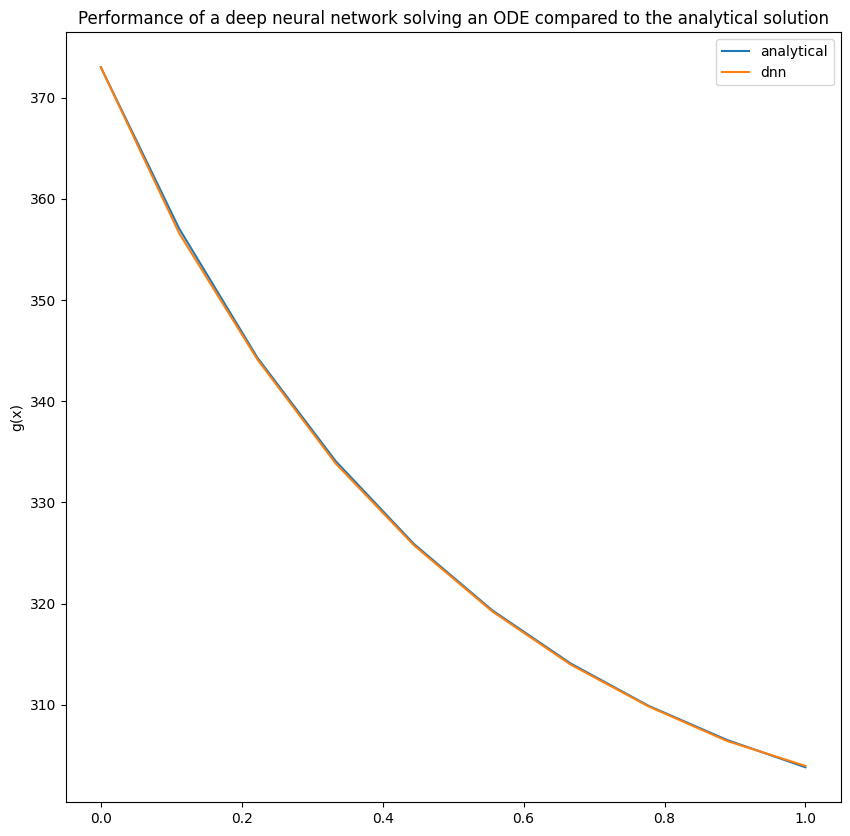

In [ ]:
import autograd.numpy as np
from autograd import grad, elementwise_grad
import autograd.numpy.random as npr
from matplotlib import pyplot as plt

def sigmoid(z):
    return 1/(1 + np.exp(-z))

# The neural network with one input layer and one output layer,
# but with number of hidden layers specified by the user.
def deep_neural_network(deep_params, x):
    # N_hidden is the number of hidden layers

    N_hidden = np.size(deep_params) - 1 # -1 since params consists of
                                        # parameters to all the hidden
                                        # layers AND the output layer.

    # Assumes input x being an one-dimensional array
    num_values = np.size(x)
    x = x.reshape(-1, num_values)

    # Assume that the input layer does nothing to the input x
    x_input = x

    # Due to multiple hidden layers, define a variable referencing to the
    # output of the previous layer:
    x_prev = x_input

    ## Hidden layers:

    for l in range(N_hidden):
        # From the list of parameters P; find the correct weigths and bias for this layer
        w_hidden = deep_params[l]

        # Add a row of ones to include bias
        x_prev = np.concatenate((np.ones((1,num_values)), x_prev ), axis = 0)

        z_hidden = np.matmul(w_hidden, x_prev)
        x_hidden = sigmoid(z_hidden)

        # Update x_prev such that next layer can use the output from this layer
        x_prev = x_hidden

    ## Output layer:

    # Get the weights and bias for this layer
    w_output = deep_params[-1]

    # Include bias:
    x_prev = np.concatenate((np.ones((1,num_values)), x_prev), axis = 0)

    z_output = np.matmul(w_output, x_prev)
    x_output = z_output

    return x_output

# The trial solution using the deep neural network:
def g_trial_deep(t,params, t0 = 373):
    return t0 + t*deep_neural_network(params, t)

# The right side of the ODE:
def g(x, g_trial, gamma = 2):
    tA = 293
    return -gamma*(g_trial-tA)

# The same cost function as before, but calls deep_neural_network instead.
def cost_function_deep(P, x):

    # Evaluate the trial function with the current parameters P
    g_t = g_trial_deep(x,P)

    # Find the derivative w.r.t x of the neural network
    d_net_out = elementwise_grad(deep_neural_network,1)(P,x)

    # Find the derivative w.r.t x of the trial function
    d_g_t = elementwise_grad(g_trial_deep,0)(x,P)

    # The right side of the ODE
    func = g(x, g_t)

    err_sqr = (d_g_t - func)**2
    cost_sum = np.sum(err_sqr)

    return cost_sum / np.size(err_sqr)

# Solve the exponential decay ODE using neural network with one input and one output layer,
# but with specified number of hidden layers from the user.
def solve_ode_deep_neural_network(x, num_neurons, num_iter, lmb):
    # num_hidden_neurons is now a list of number of neurons within each hidden layer

    # The number of elements in the list num_hidden_neurons thus represents
    # the number of hidden layers.

    # Find the number of hidden layers:
    N_hidden = np.size(num_neurons)

    ## Set up initial weights and biases

    # Initialize the list of parameters:
    P = [None]*(N_hidden + 1) # + 1 to include the output layer

    P[0] = npr.randn(num_neurons[0], 2 )
    for l in range(1,N_hidden):
        P[l] = npr.randn(num_neurons[l], num_neurons[l-1] + 1) # +1 to include bias

    # For the output layer
    P[-1] = npr.randn(1, num_neurons[-1] + 1 ) # +1 since bias is included

    print('Initial cost: %g'%cost_function_deep(P, x))

    ## Start finding the optimal weights using gradient descent

    # Find the Python function that represents the gradient of the cost function
    # w.r.t the 0-th input argument -- that is the weights and biases in the hidden and output layer
    cost_function_deep_grad = grad(cost_function_deep,0)

    # Let the update be done num_iter times
    for i in range(num_iter):
        # Evaluate the gradient at the current weights and biases in P.
        # The cost_grad consist now of N_hidden + 1 arrays; the gradient w.r.t the weights and biases
        # in the hidden layers and output layers evaluated at x.
        cost_deep_grad =  cost_function_deep_grad(P, x)

        for l in range(N_hidden+1):
            P[l] = P[l] - lmb * cost_deep_grad[l]

    print('Final cost: %g'%cost_function_deep(P, x))

    return P

def g_analytic(t, gamma = 2, t0 = 373):
    tA = 293
    return tA + 80*np.exp(-gamma*t)

# Solve the given problem
if __name__ == '__main__':
    npr.seed(15)

    ## Decide the vales of arguments to the function to solve
    N = 10
    x = np.linspace(0, 1, N)

    ## Set up the initial parameters
    num_hidden_neurons = np.array([15,10])
    num_iter = 5000
    lmb = 0.01

    P = solve_ode_deep_neural_network(x, num_hidden_neurons, num_iter, lmb)

    res = g_trial_deep(x,P)
    res_analytical = g_analytic(x)

    plt.figure(figsize=(10,10))

    plt.title('Performance of a deep neural network solving an ODE compared to the analytical solution')
    plt.plot(x, res_analytical)
    plt.plot(x, res[0,:])
    plt.legend(['analytical','dnn'])
    plt.ylabel('g(x)')
    plt.show()

# Burger's

In [ ]:
import tensorflow as tf

In [ ]:
import autograd.numpy as np
from autograd import grad, elementwise_grad
import autograd.numpy.random as npr
from matplotlib import pyplot as plt
import math
def sigmoid(z):
    return 1/(1 + np.exp(-z))

# The neural network with one input layer and one output layer,
# but with number of hidden layers specified by the user.
def deep_neural_network(deep_params, x):
    # N_hidden is the number of hidden layers

    N_hidden = np.size(deep_params) - 1 # -1 since params consists of
                                        # parameters to all the hidden
                                        # layers AND the output layer.

    # Assumes input x being an one-dimensional array
    num_values = np.size(x)
    x = x.reshape(-1, num_values)

    # Assume that the input layer does nothing to the input x
    x_input = x

    # Due to multiple hidden layers, define a variable referencing to the
    # output of the previous layer:
    x_prev = x_input

    ## Hidden layers:

    for l in range(N_hidden):
        # From the list of parameters P; find the correct weigths and bias for this layer
        w_hidden = deep_params[l]

        # Add a row of ones to include bias
        x_prev = np.concatenate((np.ones((1,num_values)), x_prev ), axis = 0)

        z_hidden = np.matmul(w_hidden, x_prev)
        x_hidden = sigmoid(z_hidden)

        # Update x_prev such that next layer can use the output from this layer
        x_prev = x_hidden

    ## Output layer:

    # Get the weights and bias for this layer
    w_output = deep_params[-1]

    # Include bias:
    x_prev = np.concatenate((np.ones((1,num_values)), x_prev), axis = 0)

    z_output = np.matmul(w_output, x_prev)
    x_output = z_output

    return x_output

def u(t, x):
    # u = neural_net(tf.concat([t,x],1), weights, biases)
    u = deep_neural_network(t,x)
    return u

def f(t, x):
    u = u(t, x)
    u_t = tf.gradients(u, t)[0]
    u_x = tf.gradients(u, x)[0]
    u_xx = tf.gradients(u_x, x)[0]
    f = u_t + u*u_x - (0.01/tf.pi)*u_xx
    return f



# The trial solution using the deep neural network:
def g_trial_deep(t,params, t0 = 373):
    # return t0 + t*deep_neural_network(params, t)
    return (1 - 1/(4*math.pow(t,2))*math.pow((1+math.sqrt(1+4*t*(t-x))),2))

# The right side of the ODE:
def g(x,t):
    t = 293
    # return -gamma*(g_trial-tA)
    return f(t, x)

# The same cost function as before, but calls deep_neural_network instead.
def cost_function_deep(P, x):

    # Evaluate the trial function with the current parameters P
    g_t = g_trial_deep(x,P)

    # Find the derivative w.r.t x of the neural network
    d_net_out = elementwise_grad(deep_neural_network,1)(P,x)

    # Find the derivative w.r.t x of the trial function
    d_g_t = elementwise_grad(g_trial_deep,0)(x,P)

    # The right side of the ODE
    func = g(x, g_t)

    err_sqr = (d_g_t - func)**2
    cost_sum = np.sum(err_sqr)

    return cost_sum / np.size(err_sqr)

# Solve the exponential decay ODE using neural network with one input and one output layer,
# but with specified number of hidden layers from the user.
def solve_ode_deep_neural_network(x, num_neurons, num_iter, lmb):
    # num_hidden_neurons is now a list of number of neurons within each hidden layer

    # The number of elements in the list num_hidden_neurons thus represents
    # the number of hidden layers.

    # Find the number of hidden layers:
    N_hidden = np.size(num_neurons)

    ## Set up initial weights and biases

    # Initialize the list of parameters:
    P = [None]*(N_hidden + 1) # + 1 to include the output layer

    P[0] = npr.randn(num_neurons[0], 2 )
    for l in range(1,N_hidden):
        P[l] = npr.randn(num_neurons[l], num_neurons[l-1] + 1) # +1 to include bias

    # For the output layer
    P[-1] = npr.randn(1, num_neurons[-1] + 1 ) # +1 since bias is included

    print('Initial cost: %g'%cost_function_deep(P, x))

    ## Start finding the optimal weights using gradient descent

    # Find the Python function that represents the gradient of the cost function
    # w.r.t the 0-th input argument -- that is the weights and biases in the hidden and output layer
    cost_function_deep_grad = grad(cost_function_deep,0)

    # Let the update be done num_iter times
    for i in range(num_iter):
        # Evaluate the gradient at the current weights and biases in P.
        # The cost_grad consist now of N_hidden + 1 arrays; the gradient w.r.t the weights and biases
        # in the hidden layers and output layers evaluated at x.
        cost_deep_grad =  cost_function_deep_grad(P, x)

        for l in range(N_hidden+1):
            P[l] = P[l] - lmb * cost_deep_grad[l]

    print('Final cost: %g'%cost_function_deep(P, x))

    return P

def g_analytic(t, gamma = 2, t0 = 373):
    tA = 293
    return tA + 80*np.exp(-gamma*t)

# Solve the given problem
if __name__ == '__main__':
    npr.seed(15)

    ## Decide the vales of arguments to the function to solve
    N = 10
    x = np.linspace(0, 1, N)

    ## Set up the initial parameters
    num_hidden_neurons = np.array([15,10])
    num_iter = 5000
    lmb = 0.01

    P = solve_ode_deep_neural_network(x, num_hidden_neurons, num_iter, lmb)

    res = g_trial_deep(x,P)
    res_analytical = g_analytic(x)

    plt.figure(figsize=(10,10))

    plt.title('Performance of a deep neural network solving an ODE compared to the analytical solution')
    plt.plot(x, res_analytical)
    plt.plot(x, res[0,:])
    plt.legend(['analytical','dnn'])
    plt.ylabel('g(x)')
    plt.show()

TypeError: ignored

DON'T Pay attention to the below code

In [ ]:
#! /usr/bin/env python3
#
def burgers_solution_test ( ):

#*****************************************************************************80
#
## burgers_solution_test tests burgers_solution.
#
#  Licensing:
#
#    This code is distributed under the GNU LGPL license.
#
#  Modified:
#
#    27 September 2015
#
#  Author:
#
#    John Burkardt
#
  import platform

  print ( '' )
  print ( 'burgers_solution_test():' )
  print ( '  Python version: %s' % ( platform.python_version ( ) ) )
  print ( '  burgers_solution evaluates exact solutions of the Burgers equation.' )

  burgers_viscous_time_exact1_test01 ( )
  burgers_viscous_time_exact1_test02 ( )
  burgers_viscous_time_exact2_test01 ( )
  burgers_viscous_time_exact2_test02 ( )
#
#  Terminate.
#
  print ( '' )
  print ( 'burgers_solution_test():' )
  print ( '  Normal end of execution.' )
  return

def burgers_viscous_time_exact1 ( nu, vxn, vx, vtn, vt ):

#*****************************************************************************80
#
## burgers_viscous_time_exact1() evaluates a solution to the Burgers equation.
#
#  Discussion:
#
#    The form of the Burgers equation considered here is
#
#      du       du        d^2 u
#      -- + u * -- = nu * -----
#      dt       dx        dx^2
#
#    for -1.0 < x < +1.0, and 0 < t.
#
#    Initial conditions are u(x,0) = - sin(pi*x).  Boundary conditions
#    are u(-1,t) = u(+1,t) = 0.  The viscosity parameter nu is taken
#    to be 0.01 / pi, although this is not essential.
#
#    The authors note an integral representation for the solution u(x,t),
#    and present a better version of the formula that is amenable to
#    approximation using Hermite quadrature.
#
#    This program library does little more than evaluate the exact solution
#    at a user-specified set of points, using the quadrature rule.
#    Internally, the order of this quadrature rule is set to 8, but the
#    user can easily modify this value if greater accuracy is desired.
#
#  Licensing:
#
#    This code is distributed under the GNU LGPL license.
#
#  Modified:
#
#    24 September 2015
#
#  Author:
#
#    John Burkardt.
#
#  Reference:
#
#    Claude Basdevant, Michel Deville, Pierre Haldenwang, J Lacroix,
#    J Ouazzani, Roger Peyret, Paolo Orlandi, Anthony Patera,
#    Spectral and finite difference solutions of the Burgers equation,
#    Computers and Fluids,
#    Volume 14, Number 1, 1986, pages 23-41.
#
#  Input:
#
#    real NU, the viscosity.
#
#    integer VXN, the number of spatial grid points.
#
#    real VX(VXN), the spatial grid points.
#
#    integer VTN, the number of time grid points.
#
#    real VT(VTN), the time grid points.
#
#  Output:
#
#    real VU(VXN,VTN), the solution of the Burgers
#    equation at each space and time grid point.
#
  import numpy as np

  qn = 8
#
#  Compute the rule.
#
  qx, qw = hermite_ek_compute ( qn )
#
#  Evaluate U(X,T) for later times.
#
  vu = np.zeros ( [ vxn, vtn ] )

  for vti in range ( 0, vtn ):

    if ( vt[vti] == 0.0 ):

      for i in range ( 0, vxn ):
        vu[i,vti] = - np.sin ( np.pi * vx[i] )

    else:

      for vxi in range ( 0, vxn ):

        top = 0.0
        bot = 0.0

        for qi in range ( 0, qn ):

          c = 2.0 * np.sqrt ( nu * vt[vti] )

          top = top - qw[qi] * c * np.sin ( np.pi * ( vx[vxi] - c * qx[qi] ) ) \
            * np.exp ( - np.cos ( np.pi * ( vx[vxi] - c * qx[qi]  ) ) \
            / ( 2.0 * np.pi * nu ) )

          bot = bot + qw[qi] * c \
            * np.exp ( - np.cos ( np.pi * ( vx[vxi] - c * qx[qi]  ) ) \
            / ( 2.0 * np.pi * nu ) )

          vu[vxi,vti] = top / bot

  return vu

def burgers_viscous_time_exact1_test01 ( ):

#*****************************************************************************80
#
## burgers_viscous_time_exact1_test01() tests sets up a small test case.
#
#  Licensing:
#
#    This code is distributed under the GNU LGPL license.
#
#  Modified:
#
#    24 September 2015
#
#  Author:
#
#    John Burkardt
#
  import numpy as np
  import platform

  vtn = 11
  vxn = 11
  nu = 0.01 / np.pi

  print ( '' )
  print ( 'burgers_viscous_time_exact1_test01():' )
  print ( '  Python version: %s' % ( platform.python_version ( ) ) )
  print ( '  burgers_viscous_time_exact1() evaluates solution #1' )
  print ( '  to the Burgers equation.' )
  print ( '' )
  print ( '  Viscosity NU = %g' % ( nu ) )
  print ( '  NX = %d' % ( vxn ) )
  print ( '  NT = %d' % ( vtn ) )

  xlo = -1.0
  xhi = +1.0
  vx = np.linspace ( xlo, xhi, vxn )
  r8vec_print ( vxn, vx, '  X grid points:' )

  tlo = 0.0
  thi = 3.0 / np.pi
  vt = np.linspace ( tlo, thi, vtn )
  r8vec_print ( vtn, vt, '  T grid points:' )

  vu = burgers_viscous_time_exact1 ( nu, vxn, vx, vtn, vt )

  r8mat_print ( vxn, vtn, vu, '  U(X,T) at grid points:' )

  filename = 'burgers_solution_test01.txt'

  r8mat_write ( filename, vxn, vtn, vu )

  print ( '' )
  print ( '  Data written to file "%s"' % ( filename ) )
#
#  Terminate
#
  print ( '' )
  print ( 'burgers_viscous_time_exact1_test01():' )
  print ( '  Normal end of execution.' )
  return

def burgers_viscous_time_exact1_test02 ( ):

#*****************************************************************************80
#
## burgers_viscous_time_exact1_test02() tests sets up a finer test case.
#
#  Licensing:
#
#    This code is distributed under the GNU LGPL license.
#
#  Modified:
#
#    24 September 2015
#
#  Author:
#
#    John Burkardt
#
  import numpy as np
  import platform

  vtn = 41
  vxn = 41
  nu = 0.01 / np.pi

  print ( '' )
  print ( 'burgers_viscous_time_exact1_test02():' )
  print ( '  Python version: %s' % ( platform.python_version ( ) ) )
  print ( '  burgers_viscous_time_exact1() computes solution #1' )
  print ( '  to the Burgers equation.' )
  print ( '' )
  print ( '  Viscosity NU = %g' % ( nu ) )
  print ( '  NX = %d' % ( vxn ) )
  print ( '  NT = %d' % ( vtn ) )

  xlo = -1.0
  xhi = +1.0
  vx = np.linspace ( xlo, xhi, vxn )
  r8vec_print ( vxn, vx, '  X grid points:' )

  tlo = 0.0
  thi = 3.0 / np.pi
  vt = np.linspace ( tlo, thi, vtn )
  r8vec_print ( vtn, vt, '  T grid points:' )

  vu = burgers_viscous_time_exact1 ( nu, vxn, vx, vtn, vt )

  filename = 'burgers_solution_test02.txt'

  r8mat_write ( filename, vxn, vtn, vu )

  print ( '' )
  print ( '  Data written to file "%s"' % ( filename ) )
#
#  Terminate
#
  print ( '' )
  print ( 'burgers_viscous_time_exact1_test02():' )
  print ( '  Normal end of execution.' )
  return

def burgers_viscous_time_exact2 ( nu, xn, x, tn, t ):

#*****************************************************************************80
#
## burgers_viscous_time_exact2() evaluates a solution to the Burgers equation.
#
#  Discussion:
#
#    The form of the Burgers equation considered here is
#
#      du       du        d^2 u
#      -- + u * -- = nu * -----
#      dt       dx        dx^2
#
#    for 0.0 < x < 2 Pi, and 0 < t.
#
#    The initial condition is
#
#      u(x,0) = 4 - 2 * nu * dphi(x,0)/dx / phi(x,0)
#
#    where
#
#      phi(x,t) = exp ( - ( x-4*t      ) / ( 4*nu*(t+1) ) )
#               + exp ( - ( x-4*t-2*pi ) / ( 4*nu*(t+1) ) )
#
#    The boundary conditions are periodic:
#
#      u(0,t) = u(2 Pi,t)
#
#    The viscosity parameter nu may be taken to be 0.01, but other values
#    may be chosen.
#
#  Licensing:
#
#    This code is distributed under the GNU LGPL license.
#
#  Modified:
#
#    27 September 2015
#
#  Author:
#
#    John Burkardt.
#
#  Reference:
#
#    Claude Basdevant, Michel Deville, Pierre Haldenwang, J Lacroix,
#    J Ouazzani, Roger Peyret, Paolo Orlandi, Anthony Patera,
#    Spectral and finite difference solutions of the Burgers equation,
#    Computers and Fluids,
#    Volume 14, Number 1, 1986, pages 23-41.
#
#  Input:
#
#    real NU, the viscosity.
#
#    integer XN, the number of spatial grid points.
#
#    real X(XN), the spatial grid points.
#
#    integer TN, the number of time grid points.
#
#    real T(TN), the time grid points.
#
#  Output:
#
#    real U(XN,TN), the solution of the Burgers
#    equation at each space and time grid point.
#
  import numpy as np

  u = np.zeros ( [ xn, tn ] )

  for j in range ( 0, tn ):

    for i in range ( 0, xn ):

      a = ( x[i] - 4.0 * t[j] )
      b = ( x[i] - 4.0 * t[j] - 2.0 * np.pi )
      c = 4.0 * nu * ( t[j] + 1.0 )
      phi = np.exp ( - a * a / c ) + np.exp ( - b * b / c )
      dphi = - 2.0 * a * np.exp ( - a * a / c ) / c \
             - 2.0 * b * np.exp ( - b * b / c ) / c
      u[i,j] = 4.0 - 2.0 * nu * dphi / phi

  return u

def burgers_viscous_time_exact2_test01 ( ):

#*****************************************************************************80
#
## burgers_viscous_time_exact2_test01() tests sets up a small test case.
#
#  Licensing:
#
#    This code is distributed under the GNU LGPL license.
#
#  Modified:
#
#    27 September 2015
#
#  Author:
#
#    John Burkardt
#
  import numpy as np
  import platform

  vtn = 11
  vxn = 11
  nu = 0.5

  print ( '' )
  print ( 'burgers_viscous_time_exact2_test01():' )
  print ( '  Python version: %s' % ( platform.python_version ( ) ) )
  print ( '  burgers_viscous_time_exact2() evaluates solution #2' )
  print ( '  to the Burgers equation.' )
  print ( '' )
  print ( '  Viscosity NU = %g' % ( nu ) )
  print ( '  NX = %d' % ( vxn ) )
  print ( '  NT = %d' % ( vtn ) )

  xlo = 0.0
  xhi = 2.0 * np.pi
  vx = np.linspace ( xlo, xhi, vxn )
  r8vec_print ( vxn, vx, '  X grid points:' )

  tlo = 0.0
  thi = 1.0
  vt = np.linspace ( tlo, thi, vtn )
  r8vec_print ( vtn, vt, '  T grid points:' )

  vu = burgers_viscous_time_exact2 ( nu, vxn, vx, vtn, vt )

  r8mat_print ( vxn, vtn, vu, '  U(X,T) at grid points:' )

  filename = 'burgers_solution_test03.txt'

  r8mat_write ( filename, vxn, vtn, vu )

  print ( '' )
  print ( '  Data written to file "%s"' % ( filename ) )
#
#  Terminate
#
  print ( '' )
  print ( 'burgers_viscous_time_exact2_test01():' )
  print ( '  Normal end of execution.' )
  return

def burgers_viscous_time_exact2_test02 ( ):

#*****************************************************************************80
#
## burgers_viscous_time_exact2_test02(): tests sets up a finer test case.
#
#  Licensing:
#
#    This code is distributed under the GNU LGPL license.
#
#  Modified:
#
#    27 September 2015
#
#  Author:
#
#    John Burkardt
#
  import numpy as np
  import platform

  vtn = 41
  vxn = 41
  nu = 0.5

  print ( '' )
  print ( 'burgers_viscous_time_exact2_test02():' )
  print ( '  Python version: %s' % ( platform.python_version ( ) ) )
  print ( '  burgers_viscous_time_exact2() computes solution #2' )
  print ( '  to the Burgers equation.' )
  print ( '' )
  print ( '  Viscosity NU = %g' % ( nu ) )
  print ( '  NX = %d' % ( vxn ) )
  print ( '  NT = %d' % ( vtn ) )

  xlo = 0.0
  xhi = 2.0 * np.pi
  vx = np.linspace ( xlo, xhi, vxn )
  r8vec_print ( vxn, vx, '  X grid points:' )

  tlo = 0.0
  thi = 1.0
  vt = np.linspace ( tlo, thi, vtn )
  r8vec_print ( vtn, vt, '  T grid points:' )

  vu = burgers_viscous_time_exact2 ( nu, vxn, vx, vtn, vt )

  filename = 'burgers_solution_test04.txt'

  r8mat_write ( filename, vxn, vtn, vu )

  print ( '' )
  print ( '  Data written to file "%s"' % ( filename ) )
#
#  Terminate
#
  print ( '' )
  print ( 'burgers_viscous_time_exact2_test02():' )
  print ( '  Normal end of execution.' )
  return

def hermite_ek_compute ( n ):

#*****************************************************************************80
#
## hermite_ek_compute() computes a Gauss-Hermite quadrature rule.
#
#  Discussion:
#
#    The code uses an algorithm by Elhay and Kautsky.
#
#    The abscissas are the zeros of the N-th order Hermite polynomial.
#
#    The integral:
#
#      integral ( -oo < x < +oo ) exp ( - x * x ) * f(x) dx
#
#    The quadrature rule:
#
#      sum ( 1 <= i <= n ) w(i) * f ( x(i) )
#
#  Licensing:
#
#    This code is distributed under the GNU LGPL license.
#
#  Modified:
#
#    15 June 2015
#
#  Author:
#
#    John Burkardt.
#
#  Reference:
#
#    Sylvan Elhay, Jaroslav Kautsky,
#    Algorithm 655: IQPACK, FORTRAN Subroutines for the Weights of
#    Interpolatory Quadrature,
#    ACM Transactions on Mathematical Software,
#    Volume 13, Number 4, December 1987, pages 399-415.
#
#  Input:
#
#    integer N, the number of abscissas.
#
#  Output:
#
#    real X(N), the abscissas.
#
#    real W(N), the weights.
#
  from scipy.special import gamma
  import numpy as np
#
#  Define the zero-th moment.
#
  zemu = gamma ( 0.5 )
#
#  Define the Jacobi matrix.
#
  bj = np.zeros ( n )
  for i in range ( 0, n ):
    bj[i] = np.sqrt ( float ( i + 1 ) / 2.0 )

  x = np.zeros ( n )

  w = np.zeros ( n )
  w[0] = np.sqrt ( zemu )
#
#  Diagonalize the Jacobi matrix.
#
  x, w = imtqlx ( n, x, bj, w )
#
#  If N is odd, force the center X to be exactly 0.
#
  if ( ( n % 2 ) == 1 ):
    x[(n-1)//2] = 0.0

  for i in range ( 0, n ):
    w[i] = w[i] ** 2

  return x, w

def hermite_ek_compute_test ( ):

#*****************************************************************************80
#
## hermite_ek_compute_test() tests hermite_ek_compute().
#
#  Licensing:
#
#    This code is distributed under the GNU LGPL license.
#
#  Modified:
#
#    15 June 2015
#
#  Author:
#
#    John Burkardt
#
  import platform

  print ( '' )
  print ( 'hermite_ek_compute_test():' )
  print ( '  Python version: %s' % ( platform.python_version ( ) ) )
  print ( '  hermite_ek_compute() computes a Hermite quadrature rule' )
  print ( '  using the Elhay-Kautsky algorithm.' )
  print ( '' )
  print ( '  Index       X             W' )

  for n in range ( 1, 11 ):

    x, w = hermite_ek_compute ( n )

    print ( '' )

    for i in range ( 0, n ):
      print ( '  %2d  %24.16g  %24.16g' % ( i, x[i], w[i] ) )
#
#  Terminate.
#
  print ( '' )
  print ( 'hermite_ek_compute_test():' )
  print ( '  Normal end of execution.' )

  return

def imtqlx ( n, d, e, z ):

#*****************************************************************************80
#
## imtqlx() diagonalizes a symmetric tridiagonal matrix.
#
#  Discussion:
#
#    This routine is a slightly modified version of the EISPACK routine to
#    perform the implicit QL algorithm on a symmetric tridiagonal matrix.
#
#    The authors thank the authors of EISPACK for permission to use this
#    routine.
#
#    It has been modified to produce the product Q' * Z, where Z is an input
#    vector and Q is the orthogonal matrix diagonalizing the input matrix.
#    The changes consist (essentially) of applying the orthogonal
#    transformations directly to Z as they are generated.
#
#  Licensing:
#
#    This code is distributed under the GNU LGPL license.
#
#  Modified:
#
#    15 June 2015
#
#  Author:
#
#    John Burkardt.
#
#  Reference:
#
#    Sylvan Elhay, Jaroslav Kautsky,
#    Algorithm 655: IQPACK, FORTRAN Subroutines for the Weights of
#    Interpolatory Quadrature,
#    ACM Transactions on Mathematical Software,
#    Volume 13, Number 4, December 1987, pages 399-415.
#
#    Roger Martin, James Wilkinson,
#    The Implicit QL Algorithm,
#    Numerische Mathematik,
#    Volume 12, Number 5, December 1968, pages 377-383.
#
#  Input:
#
#    integer N, the order of the matrix.
#
#    real D(N), the diagonal entries of the matrix.
#
#    real E(N), the subdiagonal entries of the
#    matrix, in entries E(1) through E(N-1).
#
#    real Z(N), a vector to be operated on.
#
#  Output:
#
#    real LAM(N), the diagonal entries of the diagonalized matrix.
#
#    real QTZ(N), the value of Q' * Z, where Q is the matrix that
#    diagonalizes the input symmetric tridiagonal matrix.
#
  import numpy as np

  lam = np.zeros ( n )
  for i in range ( 0, n ):
    lam[i] = d[i]

  qtz = np.zeros ( n )
  for i in range ( 0, n ):
    qtz[i] = z[i]

  if ( n == 1 ):
    return lam, qtz

  itn = 30

  epsilon = np.finfo(float).eps

  e[n-1] = 0.0

  for l in range ( 1, n + 1 ):

    j = 0

    while ( True ):

      for m in range ( l, n + 1 ):

        if ( m == n ):
          break

        if ( abs ( e[m-1] ) <= epsilon * ( abs ( lam[m-1] ) + abs ( lam[m] ) ) ):
          break

      p = lam[l-1]

      if ( m == l ):
        break

      if ( itn <= j ):
        print ( '' )
        print ( 'imtqlx - Fatal error!' )
        print ( '  Iteration limit exceeded.' )
        raise Exception ( 'imtqlx - Fatal error!' )

      j = j + 1
      g = ( lam[l] - p ) / ( 2.0 * e[l-1] )
      r = np.sqrt ( g * g + 1.0 )

      if ( g < 0.0 ):
        t = g - r
      else:
        t = g + r

      g = lam[m-1] - p + e[l-1] / ( g + t )

      s = 1.0
      c = 1.0
      p = 0.0
      mml = m - l

      for ii in range ( 1, mml + 1 ):

        i = m - ii
        f = s * e[i-1]
        b = c * e[i-1]

        if ( abs ( g ) <= abs ( f ) ):
          c = g / f
          r = np.sqrt ( c * c + 1.0 )
          e[i] = f * r
          s = 1.0 / r
          c = c * s
        else:
          s = f / g
          r = np.sqrt ( s * s + 1.0 )
          e[i] = g * r
          c = 1.0 / r
          s = s * c

        g = lam[i] - p
        r = ( lam[i-1] - g ) * s + 2.0 * c * b
        p = s * r
        lam[i] = g + p
        g = c * r - b
        f = qtz[i]
        qtz[i]   = s * qtz[i-1] + c * f
        qtz[i-1] = c * qtz[i-1] - s * f

      lam[l-1] = lam[l-1] - p
      e[l-1] = g
      e[m-1] = 0.0

  for ii in range ( 2, n + 1 ):

     i = ii - 1
     k = i
     p = lam[i-1]

     for j in range ( ii, n + 1 ):

       if ( lam[j-1] < p ):
         k = j
         p = lam[j-1]

     if ( k != i ):

       lam[k-1] = lam[i-1]
       lam[i-1] = p

       p        = qtz[i-1]
       qtz[i-1] = qtz[k-1]
       qtz[k-1] = p

  return lam, qtz

def imtqlx_test ( ):

#*****************************************************************************80
#
## imtqlx_test() tests imtqlx().
#
#  Licensing:
#
#    This code is distributed under the GNU LGPL license.
#
#  Modified:
#
#    15 June 2015
#
#  Author:
#
#    John Burkardt.
#
  import numpy as np
  import platform

  print ( '' )
  print ( 'imtqlx_test():' )
  print ( '  Python version: %s' % ( platform.python_version ( ) ) )
  print ( '  imtqlx() takes a symmetric tridiagonal matrix A' )
  print ( '  and computes its eigenvalues LAM.' )
  print ( '  It also accepts a vector Z and computes Q\'*Z,' )
  print ( '  where Q is the matrix that diagonalizes A.' )

  n = 5
  d = np.zeros ( n )
  for i in range ( 0, n ):
    d[i] = 2.0;
  e = np.zeros ( n )
  for i in range ( 0, n - 1 ):
    e[i] = -1.0
  e[n-1] = 0.0
  z = np.ones ( n )

  lam, qtz = imtqlx ( n, d, e, z )

  r8vec_print ( n, lam, '  Computed eigenvalues:' )

  lam2 = np.zeros ( n )
  for i in range ( 0, n ):
    angle = float ( i + 1 ) * np.pi / float ( 2 * ( n + 1 ) )
    lam2[i] = 4.0 * ( np.sin ( angle ) ) ** 2

  r8vec_print ( n, lam2, '  Exact eigenvalues:' )

  r8vec_print ( n, z, '  Vector Z:' )
  r8vec_print ( n, qtz, '  Vector Q''*Z:' )
#
#  Terminate.
#
  print ( '' )
  print ( 'imtqlx_test:' )
  print ( '  Normal end of execution.' )
  return

def r8mat_print ( m, n, a, title ):

#*****************************************************************************80
#
## r8mat_print() prints an R8MAT.
#
#  Licensing:
#
#    This code is distributed under the GNU LGPL license.
#
#  Modified:
#
#    31 August 2014
#
#  Author:
#
#    John Burkardt
#
#  Input:
#
#    integer M, the number of rows in A.
#
#    integer N, the number of columns in A.
#
#    real A(M,N), the matrix.
#
#    string TITLE, a title.
#
  r8mat_print_some ( m, n, a, 0, 0, m - 1, n - 1, title )

  return

def r8mat_print_test ( ):

#*****************************************************************************80
#
## r8mat_print_test() tests r8mat_print().
#
#  Licensing:
#
#    This code is distributed under the GNU LGPL license.
#
#  Modified:
#
#    10 February 2015
#
#  Author:
#
#    John Burkardt
#
  import numpy as np
  import platform

  print ( '' )
  print ( 'r8mat_print_test():' )
  print ( '  Python version: %s' % ( platform.python_version ( ) ) )
  print ( '  r8mat_print() prints an R8MAT.' )

  m = 4
  n = 6
  v = np.array ( [ \
    [ 11.0, 12.0, 13.0, 14.0, 15.0, 16.0 ],
    [ 21.0, 22.0, 23.0, 24.0, 25.0, 26.0 ],
    [ 31.0, 32.0, 33.0, 34.0, 35.0, 36.0 ],
    [ 41.0, 42.0, 43.0, 44.0, 45.0, 46.0 ] ], dtype = np.float64 )
  r8mat_print ( m, n, v, '  Here is an R8MAT:' )
#
#  Terminate.
#
  print ( '' )
  print ( 'r8mat_print_test():' )
  print ( '  Normal end of execution.' )
  return

def r8mat_print_some ( m, n, a, ilo, jlo, ihi, jhi, title ):

#*****************************************************************************80
#
## r8mat_print_some() prints out a portion of an R8MAT.
#
#  Licensing:
#
#    This code is distributed under the GNU LGPL license.
#
#  Modified:
#
#    10 February 2015
#
#  Author:
#
#    John Burkardt
#
#  Input:
#
#    integer M, N, the number of rows and columns of the matrix.
#
#    real A(M,N), an M by N matrix to be printed.
#
#    integer ILO, JLO, the first row and column to print.
#
#    integer IHI, JHI, the last row and column to print.
#
#    string TITLE, a title.
#
  incx = 5

  print ( '' )
  print ( title )

  if ( m <= 0 or n <= 0 ):
    print ( '' )
    print ( '  (None)' )
    return

  for j2lo in range ( max ( jlo, 0 ), min ( jhi + 1, n ), incx ):

    j2hi = j2lo + incx - 1
    j2hi = min ( j2hi, n )
    j2hi = min ( j2hi, jhi )

    print ( '' )
    print ( '  Col: ', end = '' )

    for j in range ( j2lo, j2hi + 1 ):
      print ( '%7d       ' % ( j ), end = '' )

    print ( '' )
    print ( '  Row' )

    i2lo = max ( ilo, 0 )
    i2hi = min ( ihi, m )

    for i in range ( i2lo, i2hi + 1 ):

      print ( '%7d :' % ( i ), end = '' )

      for j in range ( j2lo, j2hi + 1 ):
        print ( '%12g  ' % ( a[i,j] ), end = '' )

      print ( '' )

  return

def r8mat_print_some_test ( ):

#*****************************************************************************80
#
## r8mat_print_some_test() tests r8mat_print_some.
#
#  Licensing:
#
#    This code is distributed under the GNU LGPL license.
#
#  Modified:
#
#    31 October 2014
#
#  Author:
#
#    John Burkardt
#
  import numpy as np
  import platform

  print ( '' )
  print ( 'r8mat_print_some_test():' )
  print ( '  Python version: %s' % ( platform.python_version ( ) ) )
  print ( '  r8mat_print_some() prints some of an R8MAT.' )

  m = 4
  n = 6
  v = np.array ( [ \
    [ 11.0, 12.0, 13.0, 14.0, 15.0, 16.0 ],
    [ 21.0, 22.0, 23.0, 24.0, 25.0, 26.0 ],
    [ 31.0, 32.0, 33.0, 34.0, 35.0, 36.0 ],
    [ 41.0, 42.0, 43.0, 44.0, 45.0, 46.0 ] ], dtype = np.float64 )
  r8mat_print_some ( m, n, v, 0, 3, 2, 5, '  Here is an R8MAT:' )
#
#  Terminate.
#
  print ( '' )
  print ( 'r8mat_print_some_test():' )
  print ( '  Normal end of execution.' )
  return

def r8mat_write ( filename, m, n, a ):

#*****************************************************************************80
#
## r8mat_write() writes an R8MAT to a file.
#
#  Licensing:
#
#    This code is distributed under the GNU LGPL license.
#
#  Modified:
#
#    12 October 2014
#
#  Author:
#
#    John Burkardt
#
#  Input:
#
#    string FILENAME, the name of the output file.
#
#    integer M, the number of rows in A.
#
#    integer N, the number of columns in A.
#
#    real A(M,N), the matrix.
#
  output = open ( filename, 'w' )

  for i in range ( 0, m ):
    for j in range ( 0, n ):
      s = '  %g' % ( a[i,j] )
      output.write ( s )
    output.write ( '\n' )

  output.close ( )

  return

def r8mat_write_test ( ):

#*****************************************************************************80
#
## r8mat_write_test() tests r8mat_write().
#
#  Licensing:
#
#    This code is distributed under the GNU LGPL license.
#
#  Modified:
#
#    12 October 2014
#
#  Author:
#
#    John Burkardt
#
  import numpy as np
  import platform

  print ( '' )
  print ( 'r8mat_write_test():' )
  print ( '  Python version: %s' % ( platform.python_version ( ) ) )
  print ( '  r8mat_write() writes an R8MAT to a file.' )

  filename = 'r8mat_write_test.txt'
  m = 5
  n = 3
  a = np.array ( (  \
    ( 1.1, 1.2, 1.3 ), \
    ( 2.1, 2.2, 2.3 ), \
    ( 3.1, 3.2, 3.3 ), \
    ( 4.1, 4.2, 4.3 ), \
    ( 5.1, 5.2, 5.3 ) ) )
  r8mat_write ( filename, m, n, a )

  print ( '' )
  print ( '  Created file "%s".' % ( filename ) )
#
#  Terminate.
#
  print ( '' )
  print ( 'r8mat_write_test():' )
  print ( '  Normal end of execution.' )
  return

def r8_sign ( x ):

#*****************************************************************************80
#
## r8_sign() returns the sign of an R8.
#
#  Discussion:
#
#    The value is +1 if the number is positive or zero, and it is -1 otherwise.
#
#  Licensing:
#
#    This code is distributed under the GNU LGPL license.
#
#  Modified:
#
#    03 June 2013
#
#  Author:
#
#    John Burkardt
#
#  Input:
#
#    real X, the number whose sign is desired.
#
#  Output:
#
#    real VALUE, the sign of X.
#
  if ( x < 0.0 ):
    value = -1.0
  else:
    value = +1.0

  return value

def r8_sign_test ( ):

#*****************************************************************************80
#
## r8_sign_test() tests r8_sign().
#
#  Licensing:
#
#    This code is distributed under the GNU LGPL license.
#
#  Modified:
#
#    28 September 2014
#
#  Author:
#
#    John Burkardt
#
  import numpy as np
  import platform

  test_num = 5

  r8_test = np.array ( [ -1.25, -0.25, 0.0, +0.5, +9.0 ] )

  print ( '' )
  print ( 'r8_sign_test():' )
  print ( '  Python version: %s' % ( platform.python_version ( ) ) )
  print ( '  r8_sign() returns the sign of an R8.' )
  print ( '' )
  print ( '     R8     r8_sign(R8)' )
  print ( '' )

  for test in range ( 0, test_num ):
    r8 = r8_test[test]
    s = r8_sign ( r8 )
    print ( '  %8.4f  %8.0f' % ( r8, s ) )
#
#  Terminate.
#
  print ( '' )
  print ( 'r8_sign_test()' )
  print ( '  Normal end of execution.' )
  return

def r8vec_print ( n, a, title ):

#*****************************************************************************80
#
## r8vec_print() prints an R8VEC.
#
#  Licensing:
#
#    This code is distributed under the GNU LGPL license.
#
#  Modified:
#
#    31 August 2014
#
#  Author:
#
#    John Burkardt
#
#  Input:
#
#    integer N, the dimension of the vector.
#
#    real A(N), the vector to be printed.
#
#    string TITLE, a title.
#
  print ( '' )
  print ( title )
  print ( '' )
  for i in range ( 0, n ):
    print ( '%6d:  %12g' % ( i, a[i] ) )

def r8vec_print_test ( ):

#*****************************************************************************80
#
## r8vec_print_test() tests r8vec_print().
#
#  Licensing:
#
#    This code is distributed under the GNU LGPL license.
#
#  Modified:
#
#    29 October 2014
#
#  Author:
#
#    John Burkardt
#
  import numpy as np
  import platform

  print ( '' )
  print ( 'r8vec_print_test():' )
  print ( '  Python version: %s' % ( platform.python_version ( ) ) )
  print ( '  r8vec_print() prints an R8VEC.' )

  n = 4
  v = np.array ( [ 123.456, 0.000005, -1.0E+06, 3.14159265 ], dtype = np.float64 )
  r8vec_print ( n, v, '  Here is an R8VEC:' )
#
#  Terminate.
#
  print ( '' )
  print ( 'r8vec_print_test():' )
  print ( '  Normal end of execution.' )
  return

def timestamp ( ):

#*****************************************************************************80
#
## timestamp() prints the date as a timestamp.
#
#  Licensing:
#
#    This code is distributed under the GNU LGPL license.
#
#  Modified:
#
#    06 April 2013
#
#  Author:
#
#    John Burkardt
#
  import time

  t = time.time ( )
  print ( time.ctime ( t ) )

  return None

if ( __name__ == '__main__' ):
  timestamp ( )
  burgers_solution_test ( )
  timestamp ( )


Tue Jun 27 02:19:21 2023

burgers_solution_test():
  Python version: 3.10.12
  burgers_solution evaluates exact solutions of the Burgers equation.

burgers_viscous_time_exact1_test01():
  Python version: 3.10.12
  burgers_viscous_time_exact1() evaluates solution #1
  to the Burgers equation.

  Viscosity NU = 0.0031831
  NX = 11
  NT = 11

  X grid points:

     0:            -1
     1:          -0.8
     2:          -0.6
     3:          -0.4
     4:          -0.2
     5:             0
     6:           0.2
     7:           0.4
     8:           0.6
     9:           0.8
    10:             1

  T grid points:

     0:             0
     1:      0.095493
     2:      0.190986
     3:      0.286479
     4:      0.381972
     5:      0.477465
     6:      0.572958
     7:      0.668451
     8:      0.763944
     9:      0.859437
    10:       0.95493

  U(X,T) at grid points:

  Col:       0             1             2             3             4       
  Row
      0 : 1.22465e-16   1.